## **Single-Env Training**

In [9]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
env = gym.make("CartPole-v1")
env = Monitor(env, filename = os.path.join(log_path, "0.monitor.csv"))    # Monitor the environment for logging
env = DummyVecEnv([lambda: env])                                          # Wrap the environment in a DummyVecEnv


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = env, 
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)    # Tensorboard log folder location              # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 20000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-04_16-23-24   

Logging to Training\2025-05-04_16-23-24\PPO_1
Eval num_timesteps=1000, episode_reward=9.15 +/- 0.79
Episode length: 9.15 +/- 0.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.15     |
|    mean_reward     | 9.15     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.25 +/- 0.62
Episode length: 9.25 +/- 0.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.25     |
|    mean_reward     | 9.25     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 1553     |


## **Multi-Env Training**
Faster then training in single environment

In [4]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

In [15]:
# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
vec_env = make_vec_env(env_id = "CartPole-v1", 
                       n_envs = 8, 
                       monitor_dir = log_path)      # Create multiple environments and monitor them


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = vec_env, 
            n_steps = 256,                   # ← 重点：减小 rollout 长度
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)      # Tensorboard log folder location            # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(vec_env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 50000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-15_20-13-03   

Logging to Training\2025-05-15_20-13-03\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 4973     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 27.4       |
|    ep_rew_mean          | 27.4       |
| time/                   |            |
|    fps                  | 1536       |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00841536 |
|    clip_fraction        | 0.092      |
|    clip_range           | 0.2        |
|    entropy_loss  

In [16]:
# 评估模型
# Test the model
import os
import tools
PPO_Model_Path = os.path.join(log_path, "model_full_training")
tools.test_model("PPO", PPO_Model_Path, n_episodes=2, render = True)

Training\2025-05-15_20-13-03\model_full_training

Episode: 1 Score: 500.0
Episode: 2 Score: 500.0


Plotting path is:  Training\2025-05-15_20-13-03


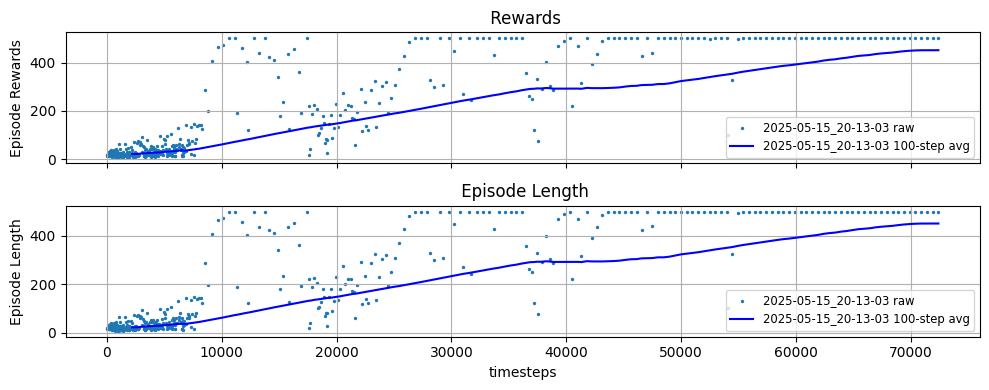

In [17]:
# 绘制结果
# Plotting the results
import tools
print("Plotting path is: ", log_path)
tools.plot_result(dirs=[log_path],
                  window = 100)

# Plot Multi-Training Results
# tools.plot_result(dirs=["Training\\2025-05-04_16-23-24", "Training\\2025-05-04_16-24-35"],
#                   window = 100)

## **生成轨迹 Pair**

In [4]:
import os
import pandas as pd
import gym
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo
from tools import test_model, plot_result

In [60]:
from stable_baselines3 import PPO, DQN
import gymnasium as gym
import os

# log_path = "Training\\2025-05-15_20-13-03"

model_pi_1_path = os.path.join(log_path, "model_full_training.zip")
model_pi_2_path = os.path.join(log_path, "model_at_reward_200.zip")

model_pi_1 = PPO.load(model_pi_1_path, device="cpu")
model_pi_2 = PPO.load(model_pi_2_path, device="cpu")

test_model("PPO", model_pi_1_path, n_episodes=100, render=False, record=False, traj=True)
test_model("PPO", model_pi_2_path, n_episodes=100, render=False, record=False, traj=True)

test_model("PPO", model_pi_1_path, n_episodes=1, render=False, record=True)
test_model("PPO", model_pi_2_path, n_episodes=1, render=False, record=True)

NameError: name 'log_path' is not defined

In [25]:
# RLHF 
#   训练的 RLHF 会根据 trajectory 返回分数

# 加载轨迹数据
import numpy as np
import pandas as pd

trajectory_path_pi1 = os.path.join(log_path, "trajectory", "Pi-1-trajectory-0.csv")

df = pd.read_csv(trajectory_path_pi1)

print(df.columns)
print(df['reward'])            # 取出 reward 列
np.sum(np.array(df['reward'])) # 将 pandas 数据转为 numpy 数组

Index(['episode', 'step', 'x', 'x_dot', 'theta', 'theta_dot', 'action',
       'reward'],
      dtype='object')
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
495    1.0
496    1.0
497    1.0
498    1.0
499    1.0
Name: reward, Length: 500, dtype: float64


np.float64(500.0)

In [ ]:
import glob, os, re, pandas as pd
import numpy as np
import random
import json

class RLHF_class:
    def __init__(self, path):

        # 初始化数据
        self.path = path
        self.reward_pi_1 = []
        self.reward_pi_2 = []
        self.traj_list_1 = []
        self.traj_list_2 = []

        self.traj_prefer = []
        self.traj_reject = []
        self.choose_probs = None

        # 启动函数
        self.read_pattern()             # 一次性扫 Pi-1, Pi-2, … 各类文件
        self.compute_total_reward()     # 计算每个 Pi 的总奖励
        self.comput_RLHF_prob(self.reward_pi_1, self.reward_pi_2)
        self.store_trajectory_and_action_pair()         # 将轨迹数据存储到 traj_list_1, traj_list_2 中
        self.select_prefer_and_reject_traj()
        self.make_csv()                # 将数据存储到 csv 文件中

    def read_pattern(self):

        # 1. 扫描所有 Pi-*-trajectory-*.csv
        pattern = os.path.join(self.path, 'Pi-*-trajectory-*.csv')
        all_files = glob.glob(pattern)

        # 2. 按前缀 Pi-1, Pi-2… 分组
        groups = {}
        for fp in all_files:
            name = os.path.basename(fp)
            m = re.match(r'(Pi-\d+)-trajectory-.*\.csv', name)
            if not m:
                continue
            prefix = m.group(1)               # 比如 "Pi-1"
            groups.setdefault(prefix, []).append(fp)

        # 3. 为每个分组创建属性 data_base_1, data_base_2, …
        for idx, prefix in enumerate(sorted(groups.keys()), start=1):
            dfs = [pd.read_csv(f) for f in groups[prefix]]
            setattr(self, f"data_base_{idx}", dfs)
    
    def compute_total_reward(self):

        for data in self.data_base_1:
            reward = np.sum(data['reward'])
            self.reward_pi_1.append(reward)

        for data in self.data_base_2:
            reward = np.sum(data['reward'])
            self.reward_pi_2.append(reward)
    
    def store_trajectory_and_action_pair(self):

        self.traj_list_1 = []
        self.traj_list_2 = []

        for data in self.data_base_1:
            
            x         = np.array(data['x'])
            x_dot     = np.array(data['x_dot'])
            theta     = np.array(data['theta'])
            theta_dot = np.array(data['theta_dot'])


            state     = np.array([x, x_dot, theta, theta_dot])
            action    = np.array(data['action'])

            traj = []
            for i in range(state.shape[1]):
                traj.append({"state": state[:, i], "action": action[i]})
            
            self.traj_list_1.append(traj)
        
        
        for data in self.data_base_2:
                
            x         = np.array(data['x'])
            x_dot     = np.array(data['x_dot'])
            theta     = np.array(data['theta'])
            theta_dot = np.array(data['theta_dot'])

            state     = np.array([x, x_dot, theta, theta_dot])
            action    = np.array(data['action'])

            traj = []
            for i in range(state.shape[1]):
                traj.append({"state": state[:, i], "action": action[i]})
            
            self.traj_list_2.append(traj)
    
    def comput_RLHF_prob(self, reward1, reward2):
        """
        计算 RLHF 概率
        Compute RLHF probability
        """
        self.choose_probs = np.exp(reward1) / (np.exp(reward1) + np.exp(reward2))

    def select_prefer_and_reject_traj(self)->None:
        
        for index, prob in enumerate(self.choose_probs):
            sign = random.choices([0, 1], weights=[prob, 1 - prob])[0] # 选择 0 或 1 的概率
            if sign == 0:
                self.traj_prefer.append(self.traj_list_1[index])
                self.traj_reject.append(self.traj_list_2[index])
            else:
                self.traj_prefer.append(self.traj_list_2[index])
                self.traj_reject.append(self.traj_list_1[index])

    def make_csv(self) -> None:
        data = []
        for i in range(len(self.traj_prefer)):
            # 清洗 preferred 轨迹
            clean_pref = []
            for step in self.traj_prefer[i]:
                clean_pref.append({
                    'state': step['state'].tolist(),      # array -> list
                    'action': int(step['action'])         # np.int64 -> int
                })
            # 清洗 rejected 轨迹
            clean_rej = []
            for step in self.traj_reject[i]:
                clean_rej.append({
                    'state': step['state'].tolist(),
                    'action': int(step['action'])
                })

            data.append({
                "episode": i,
                # 把 list[dict] 序列化为标准 JSON
                "preferred": json.dumps(clean_pref, ensure_ascii=False),
                "rejected": json.dumps(clean_rej, ensure_ascii=False),
            })

        df = pd.DataFrame(data)
        parent_dir = os.path.abspath(os.path.join(self.path, os.pardir))
        df.to_csv(os.path.join(parent_dir, "RLHF_trajectory_pairs.csv"), index=False, encoding='utf-8')
        print("RLHF_trajectory_pairs.csv 已保存到：", parent_dir)
    

# 测试
trajectory_path = "Training\\2025-05-15_20-13-03\\trajectory"
# trajectory_path = os.path.join(log_path, "trajectory")
Pi = RLHF_class(trajectory_path)


Pi.data_base_1[0]
Pi.traj_list_1[0]

print(Pi.reward_pi_1)
print(Pi.reward_pi_2)

Pi.choose_probs

RLHF_trajectory_pairs.csv 已保存到： d:\EPFL\Course\MA2\[EE-568] Reinforcement Learning\EE-568-RL\PPO_Original\Training\2025-05-15_20-13-03
[np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0), np.float64(500.0)]
[np.float64(59.0), np.float64(68.0), np.float64(95.0), np.float64(28.0), np.float64(67.0), np.float64(17.0), np.float64(149.0), np.float64(115.0), np.float64(62.0), np.float64(89.0)]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [59]:
print(len(Pi.traj_prefer))

(Pi.traj_prefer[0])


10


[{'state': array([-0.04849187,  0.04277344, -0.0383825 , -0.01666123]),
  'action': np.int64(1)},
 {'state': array([-0.0476364 ,  0.23842423, -0.03871572, -0.32120293]),
  'action': np.int64(0)},
 {'state': array([-0.04286791,  0.04387439, -0.04513978, -0.04097645]),
  'action': np.int64(0)},
 {'state': array([-0.04199043, -0.15057217, -0.04595931,  0.2371297 ]),
  'action': np.int64(1)},
 {'state': array([-0.04500187,  0.04517522, -0.04121672, -0.06968862]),
  'action': np.int64(0)},
 {'state': array([-0.04409836, -0.14933231, -0.04261049,  0.20971063]),
  'action': np.int64(1)},
 {'state': array([-0.04708501,  0.04637218, -0.03841627, -0.09610336]),
  'action': np.int64(0)},
 {'state': array([-0.04615757, -0.14817871, -0.04033834,  0.18421607]),
  'action': np.int64(0)},
 {'state': array([-0.04912114, -0.34270099, -0.03665402,  0.46390584]),
  'action': np.int64(1)},
 {'state': array([-0.05597516, -0.14708073, -0.0273759 ,  0.1598987 ]),
  'action': np.int64(1)},
 {'state': array([-0